# Tutorial 1 - TMY Weather Data

This notebook explores a standard type of weather data, the typical meteorological year (TMY), and how to summarize it with python and pandas.

TMY datasets are intended to represent the weather for a typical year at a given location.  TMY datasets provide hourly solar irradiance, air temperature, wind speed, and other weather measurements for a hypothetical year that represents more or less a "median year" for solar resource.  TMY datasets are created by selecting individual months out of an extended period of weather measurememts (say, 20 years of data) to construct a single year's worth of data.  There are several methods for selecting which months to include, but the general idea is to calculate monthly summary statistics and take the month that lies in the middle of the distribution.  For example, no two Januaries will be exactly the same, so summing the total solar irradiance for each January will give a bell curve, and the month that falls closest to the middle is chosen as the representative month.  The same process is followed for February, March, and so on, and all twelve representative months are stitched together into a year-long dataset.  

The oldest TMYs were calculated using data from the nearest weather station (air ports and such).  Today, it is common to use TMYs calculated using simulated weather data from satellite imagery because of the improved spatial resolution.

To get a better feel for TMY data, we'll first explore an example TMY dataset that is bundled with pvlib.

In [5]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.8.0


## Reading a TMY dataset with pandas

First, we'll read the example dataset into a pandas DataFrame:

In [13]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, _ = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

This dataset follows the standard format of handling timeseries data with pandas -- one row per timestamp, one column per measurement type.  Because TMY files represent one year of data (no leap years), that means they'll have 8760 rows.  The number of columns can vary depending on the source of the data.

In [14]:
print("Number of rows:", len(df_tmy))
print("Number of columns:", len(df_tmy.columns))

Number of rows: 8760
Number of columns: 71


71 columns is quite a lot!  For now, let's focus just on the ones that are most important for PV modeling -- the irradiance, temperature, and wind speed columns, and extract them into a new DataFrame.

In [21]:
# GHI, DHI, DNI are irradiance measurements
# DryBulb is the "dry-bulb" (ambient) temperature
# Wspd is wind speed
df = df_tmy[['GHI', 'DHI', 'DNI', 'DryBulb', 'Wspd']]
# show the first 15 rows:
df.head(15)

,GHI,DHI,DNI,DryBulb,Wspd
1990-01-01 01:00:00-05:00,0,0,0,10.0,6.2
1990-01-01 02:00:00-05:00,0,0,0,10.0,5.2
1990-01-01 03:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 04:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 05:00:00-05:00,0,0,0,10.0,5.2
1990-01-01 06:00:00-05:00,0,0,0,10.0,4.1
1990-01-01 07:00:00-05:00,0,0,0,10.0,4.1
1990-01-01 08:00:00-05:00,9,9,1,10.0,5.2
1990-01-01 09:00:00-05:00,46,46,3,10.0,5.2
1990-01-01 10:00:00-05:00,79,78,4,10.6,5.2


## Plotting time series data with pandas and matplotlib

Let's make some plots to get a better idea of what TMY data gives us.

### Irradiance

First, the three irradiance fields:

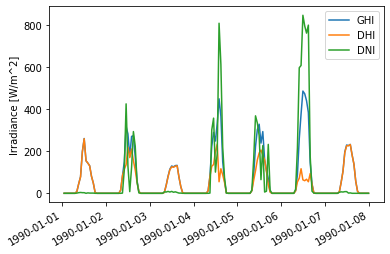

In [32]:
first_week = df.head(24*7)
first_week[['GHI', 'DHI', 'DNI']].plot()
plt.ylabel('Irradiance [W/m^2]');

GHI, DHI, and DNI are the three "basic" ways of measuring irradiance, although each of them is measured in units of power per area (watts per square meter):

- GHI: Global Horizontal Irradiance; the total sunlight intensity falling on a horizontal plane
- DHI: Diffuse Horizontal Irradiance; the subset of sunlight falling on a horizontal plane that isn't coming directly from the sun (e.g., the light that makes the sky blue)
- DNI: Direct Normal Irradiance; the subset of sunlight coming directly from the sun

Later tutorials will show how these three values are used in PV modeling.  For now, let's just get a qualitative understanding of the differences between them: looking at the above plot, there is a pattern where when DNI is high, DHI is low.  The sun puts out a (roughly) constant amount of energy, which means photons either make it through the atmosphere without scattering and are counted as direct irradiance, or they tend to get scattered and become part of the diffuse irradiance, but not both.  Looking at DNI makes it easy to pick out which hours are cloud and which are sunny -- most days in January are rather overcast with low irradiance, but the sun does occasionally break through.

In addition to daily variation, there is also seasonal variation in irradiance.  Let's compare a winter week with a summer week, using pandas to select out a summertime subset.  Notice the increased intensity in summer -- GHI peaks around 900 W/m^2, whereas in winter the maximum was more like 500 W/m^2.

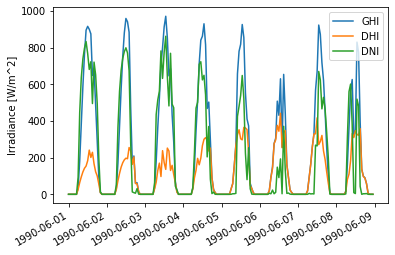

In [33]:
summer_week = df.loc['1990-06-01':'1990-06-08']
summer_week[['GHI', 'DHI', 'DNI']].plot()
plt.ylabel('Irradiance [W/m^2]');

## Temperature

Next up is temperature:

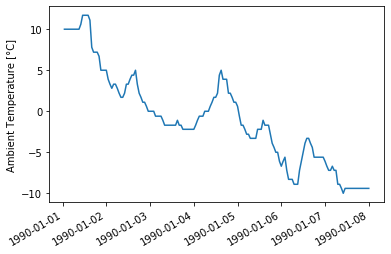

In [29]:
first_week['DryBulb'].plot()
plt.ylabel('Ambient Temperature [°C]');

### Wind speed

And finally, wind speed:

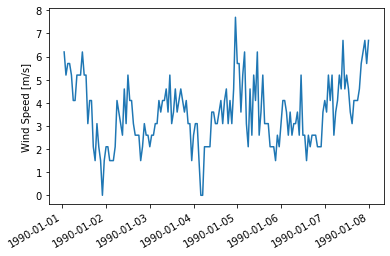

In [28]:
first_week['Wspd'].plot()
plt.ylabel('Wind Speed [m/s]');

## Aggregating hourly data to monthly summaries

Pandas makes it easy to roll-up timeseries data into summary values.  For example, we can calculate total monthly GHI as a quick way to visualize the seasonality of solar resource:

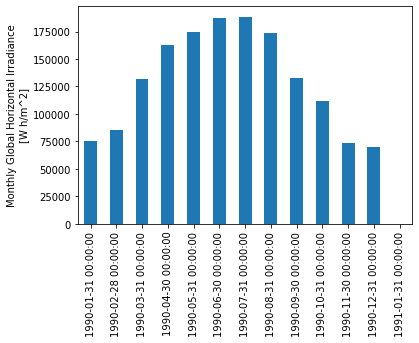

In [51]:
# summing hourly irradiance (W/m^2) gives insolation (W h/m^2)
monthly_ghi = df['GHI'].resample('M').sum()
monthly_ghi = monthly_ghi.tz_localize(None)  # don't need timezone for monthly data
monthly_ghi.plot.bar()
plt.ylabel('Monthly Global Horizontal Irradiance\n[W h/m^2]');

We can also take monthly averages instead of monthly sums:

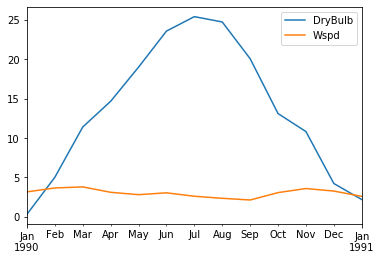

In [39]:
monthly_average_temp_wind = df[['DryBulb', 'Wspd']].resample('M').mean()
monthly_average_temp_wind.plot();

## Fetching TMYs from the NSRDB

The example TMY dataset used here is from an airport in North Carolina, but what if we wanted to model a PV system somewhere else?  The NSRDB, one of many sources of weather data intended for PV modeling, is free and easy to access using pvlib.  As an example, we'll fetch a TMY dataset for Albuquerque, New Mexico:

In [43]:
metadata, df_alb = pvlib.iotools.get_psm3(latitude=35.0844, longitude=-106.6504,
                                          api_key='DEMO_KEY',  # OK for this demo, but better to get your own key
                                          email='my_email',
                                          names='tmy')

TMY datasets from the PSM3 service of the NSRDB are timestamped using the real year that the measurements came from instead of aligning everything to a single dummy year like the TMY file above. For convenience let's standardize it to 1990 and then compare monthly GHI to the North Carolina location:

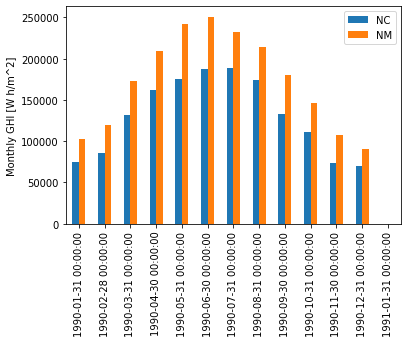

In [53]:
df_alb['Year'] = 1990
df_alb.index = pd.to_datetime(df_alb[['Year', 'Month', 'Day', 'Hour']])

ghi_comparison = pd.DataFrame({
    'NC': monthly_ghi,  # using the monthly values from earlier
    'NM': df_alb['GHI'].resample('M').sum(),
})

ghi_comparison.plot.bar()
plt.ylabel('Monthly GHI [W h/m^2]');

It's not too surprising to see that our New Mexico location is significantly sunnier than the one in North Carolina.